In [1]:
from sqlalchemy import create_engine
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import database_credentials as dc

In [2]:
# Database credentials
postgres_user = dc.user()
postgres_pw = dc.pw()
postgres_host = dc.host()
postgres_port = dc.port()
postgres_db = dc.db()

engine = create_engine('postgresql://{}:{}@{}:{}/{}'.format(
    postgres_user, postgres_pw, postgres_host, postgres_port, postgres_db))

# no need for an open connection,
# as we're only doing a single query
engine.dispose()

In [3]:
# creating a table for assigned loads
sql = '''
SELECT carrier_id, guid, id, date(assigned_date)
FROM ctms_db_public.msd_order
WHERE date(assigned_date) >= date(current_date - interval '28 days')
AND date(assigned_date) < date(current_date)
'''
assigned_loads = pd.read_sql_query(sql, con=engine)
assigned_loads = assigned_loads.rename(columns={'id': 'order_id', 'guid': 'order_guid', 'date': 'assigned_date'})
assigned_loads

,carrier_id,order_guid,order_id,assigned_date
0,18514,37d5ae71-7bdd-47e0-9b26-8f66eb59258d,7842443,2020-12-22
1,18514,a9b62439-5425-4825-8f8d-d7b72cde6de4,7842491,2020-12-22
2,30821,061db646-e320-4f0f-8e03-61a1773ab597,7842408,2020-12-22
3,18514,8f3422f2-6e44-4903-9ab4-90e5af8e91e1,7842520,2020-12-22
4,23176,2cef3251-cfa5-4c7e-a721-6eba75dd8454,7842623,2020-12-22
...,...,...,...,...
169415,42795,439225ec-e747-4e68-b8d4-a6b1889283cb,8024021,2021-01-18
169416,7611,4e48bd56-2356-49bc-93c6-c968a72956c1,8024816,2021-01-18
169417,31271,4c0c0183-c412-4b44-91dd-617ea3edf872,8025343,2021-01-18
169418,41407,e2c37874-6c5f-45f3-87e6-478cdaddc9b2,8024619,2021-01-18


In [4]:
assigned_loads.isna().sum()/assigned_loads.isna().count()

carrier_id       0.0
order_guid       0.0
order_id         0.0
assigned_date    0.0
dtype: float64

In [5]:
# creating a table for carriers
sql = '''
SELECT name, guid, id
FROM ctms_db_public.msd_carrier
WHERE test_account = FALSE
'''
carriers = pd.read_sql_query(sql, con=engine)
carriers = carriers.rename(columns={'id': 'carrier_id', 'guid': 'carrier_guid', 'name': 'carrier_name'})
carriers

,carrier_name,carrier_guid,carrier_id
0,ayman,71918a40-f1df-4b52-b925-129ed39183f1,7
1,CN2,c623837b-04ee-4cf7-a44c-bca993c4d057,16
2,Transcontinental Express LLC,e835ef60-4200-4863-916a-0eed5bd18f93,25
3,Sifuentes Auto Transport,0a142cbc-cc41-42be-96cc-9bee4dde0929,29
4,A1 USA Express,e97661bf-33fa-4b77-b4b4-23c960e54da8,37
...,...,...,...
40891,SMITH AUTO TRANSPORT,e2ddafd8-c53b-463e-ba0c-106056aa9eaa,32770
40892,TRUCKIT365 LLC,a1671f0e-302c-42e8-a2cf-2fd42ba84740,37205
40893,SUNSPHERE TRANSPORTATION AND LOGISTICS LLC,5bd114f6-85af-4ced-9da4-5896ac9a3be0,40324
40894,CARMEN & BUTCH TRUCKING COMPANY LLC,3277653c-25fc-4420-bf9b-9f71d7078026,44517


In [6]:
# Creating a table with all drivers
sql = '''
SELECT genericuser_ptr_id, carrier_id, guid
FROM ctms_db_public.msd_driver
WHERE is_suspended = False
'''
drivers = pd.read_sql_query(sql, con=engine)
drivers = drivers.rename(columns={'guid': 'driver_guid'})
drivers

,genericuser_ptr_id,carrier_id,driver_guid
0,38,20,c03bbd2c-bcf4-43bc-ac35-1a622cdf34f4
1,84,28,5e0349d6-6720-467b-b72d-f248e1be6c4d
2,101,42,bb8229f1-0cb5-46ac-8db8-05ebdb1561f0
3,117,5478,81fe5f04-ff57-4f09-b99b-86b4fab06347
4,136,5478,f65c4afc-6d34-4d74-9a0f-e7323ab305df
...,...,...,...
62973,84359,40915,a2ce78c9-52b3-48fe-91f4-5d2cd1b0a5d1
62974,84679,40996,3ef37760-55e5-43da-8d2c-c461f3ad1a41
62975,84960,37928,381eef52-a634-44f6-93f7-35a85f75ea74
62976,85358,2305,2c220ce5-1228-427f-8fde-b3e7c3ffd02e


In [7]:
# Joining carrier table with driver table
drivers_with_carrier_guid = drivers.merge(carriers, how='left',
                                          left_on='carrier_id', right_on='carrier_id')
drivers_with_carrier_guid

,genericuser_ptr_id,carrier_id,driver_guid,carrier_name,carrier_guid
0,38,20,c03bbd2c-bcf4-43bc-ac35-1a622cdf34f4,ON DEMAND AUTO TRANSPORT,711f7501-69f4-4828-9b78-118db0d15ed9
1,84,28,5e0349d6-6720-467b-b72d-f248e1be6c4d,Rum Runners Auto Transport,ad6b963f-0a4a-4b71-b643-eed8e713afce
2,101,42,bb8229f1-0cb5-46ac-8db8-05ebdb1561f0,Alt & Son Corp.,2271da16-eca1-48d6-8b67-9eeecdd6bd14
3,117,5478,81fe5f04-ff57-4f09-b99b-86b4fab06347,DUMMY ACCOUNT (DO NOT ACTIVATE),9421bc9d-fa9e-49d1-9a07-e5570d3c0b74
4,136,5478,f65c4afc-6d34-4d74-9a0f-e7323ab305df,DUMMY ACCOUNT (DO NOT ACTIVATE),9421bc9d-fa9e-49d1-9a07-e5570d3c0b74
...,...,...,...,...,...
62973,84359,40915,a2ce78c9-52b3-48fe-91f4-5d2cd1b0a5d1,2517 INC,2d596f76-0137-4a06-b14b-556bad55f2e4
62974,84679,40996,3ef37760-55e5-43da-8d2c-c461f3ad1a41,BEST YET TRUCKING INC,009b1809-d6f8-42c9-a45a-84bd18012951
62975,84960,37928,381eef52-a634-44f6-93f7-35a85f75ea74,PHL TRANSPORT INC,fc78add5-5fde-498d-a3f8-28b20d167cff
62976,85358,2305,2c220ce5-1228-427f-8fde-b3e7c3ffd02e,"Extra Mile Transport, Inc",411834a1-ddbe-49c8-970a-de52874a42ba


In [8]:
# findind the unique number of activated drivers for each carrier
active_driver_count = (drivers_with_carrier_guid.groupby(['carrier_guid', 'carrier_id', 'carrier_name'])
                                                        [['genericuser_ptr_id']].nunique())
active_driver_count.reset_index(inplace=True)
active_driver_count = active_driver_count.rename(columns={'genericuser_ptr_id': 'activated_drivers'})
active_driver_count

,carrier_guid,carrier_id,carrier_name,activated_drivers
0,000243e7-afae-455a-8e61-5c691916f39e,31952,PERFECT SERVICES LLC,1
1,0004758e-daf4-4d3f-8257-be49db385d8e,1198,Flete,1
2,000acb9e-e4bb-4cff-a5b3-3bedcf05babf,29808,R-MICHAEL ENT LLC,1
3,000b7030-5bfc-4c95-8627-df29412347ff,43133,MACROD TOWING LLC,1
4,000b8e63-986b-4bae-befe-22481e2bfc9c,32277,AB TRANSPORT SERVICE,1
...,...,...,...,...
38482,fff8e9ba-cbcd-4bf7-8f92-b00fba5ba543,9501,Alpha Transport,1
38483,fffa8e6a-3943-47f5-bc00-52f59d9cd0c6,28014,NEAGU INC,1
38484,fffb578c-7297-4ade-996d-eef9aed6c22c,9916,SAM TRANSPORT LLC,1
38485,ffff3737-7524-40a4-b225-a8832c96bf91,6038,Gshsh,1


In [9]:
# joining activated drivers table to 'assigned_loads' table

assigned_loads_with_driver_count = (assigned_loads.merge(active_driver_count,
                                    left_on='carrier_id', right_on='carrier_id'))
assigned_loads_with_driver_count

,carrier_id,order_guid,order_id,assigned_date,carrier_guid,carrier_name,activated_drivers
0,18514,37d5ae71-7bdd-47e0-9b26-8f66eb59258d,7842443,2020-12-22,f56e19fa-c5b9-4470-b01e-64caf02ff59a,jca transport services,1
1,18514,a9b62439-5425-4825-8f8d-d7b72cde6de4,7842491,2020-12-22,f56e19fa-c5b9-4470-b01e-64caf02ff59a,jca transport services,1
2,18514,8f3422f2-6e44-4903-9ab4-90e5af8e91e1,7842520,2020-12-22,f56e19fa-c5b9-4470-b01e-64caf02ff59a,jca transport services,1
3,18514,e9757b93-9e16-4856-85eb-ca798e111bcf,7842645,2020-12-22,f56e19fa-c5b9-4470-b01e-64caf02ff59a,jca transport services,1
4,18514,23548e0a-e01b-432d-819a-229fa4a29c2f,7842641,2020-12-22,f56e19fa-c5b9-4470-b01e-64caf02ff59a,jca transport services,1
...,...,...,...,...,...,...,...
169066,25269,3b4c5fd8-b4ef-4d38-97e8-4f3dcc7791f8,8005509,2021-01-15,e0020505-fd8c-4f9b-80cd-978a4ebd16b7,2 BROTHERS ENTERPRISES LLC,1
169067,44512,3ce25e94-bf3e-4858-955b-732732ab2876,8024762,2021-01-18,c48d2a33-f737-41e3-8706-b6ecfbbb3db5,T O R TRUCKING LLC,1
169068,44513,cbe30aa0-9e0b-4774-8927-23efc3076bee,8024954,2021-01-18,3e4f1768-215b-4180-bb45-bf290e5065e2,CHASE LOGISTICS INC,1
169069,37906,1ca3377c-f6b6-425b-a71c-ff9d157f1dca,8022415,2021-01-18,a012c3be-8180-402b-96fd-e8f0d36d6fed,CUJO TRANSPORT & LOGISTICS CORP,1


In [10]:
big_carriers = assigned_loads_with_driver_count['activated_drivers'] > 1
big_carriers_assigned_loads = assigned_loads_with_driver_count[big_carriers]
big_carriers_assigned_loads

,carrier_id,order_guid,order_id,assigned_date,carrier_guid,carrier_name,activated_drivers
137,38126,e839722f-f0c0-4189-bdd3-2a0b3173ea65,7842626,2020-12-22,0f635a5a-2d49-40a3-9528-914f36750ec6,COFFEE AND SONS LLC,2
138,38126,d0f68bfd-ba60-4785-941d-a9237919816b,7844775,2020-12-22,0f635a5a-2d49-40a3-9528-914f36750ec6,COFFEE AND SONS LLC,2
139,38126,9dd480de-724d-4e2c-9a2c-7b06d021469e,7849106,2020-12-22,0f635a5a-2d49-40a3-9528-914f36750ec6,COFFEE AND SONS LLC,2
140,38126,38d10dac-9419-4eaa-923e-c751f9171022,7852346,2020-12-23,0f635a5a-2d49-40a3-9528-914f36750ec6,COFFEE AND SONS LLC,2
141,38126,53501889-6739-4312-a216-61a4894d429e,7847328,2020-12-22,0f635a5a-2d49-40a3-9528-914f36750ec6,COFFEE AND SONS LLC,2
...,...,...,...,...,...,...,...
169056,33423,fc315e35-0e4f-409d-988c-09d2ae79581c,7977348,2021-01-12,70d0aca5-2c2e-448b-b2de-44f2b2871891,EXPRESS FREIGHT HAULING LLC,2
169057,39279,40bb94b7-0a49-40ee-a8d1-0b199275e68a,8019176,2021-01-18,f3c89d9c-1af9-4a72-8c93-ee3b21c009ff,CODYLAN TRANSPORTATION LLC,2
169060,24212,170f5a8b-59f7-4da1-842a-c84d16631d4e,8025314,2021-01-18,7079433d-fc9a-4b1d-8266-1e814f01d587,INTERNATIONAL TRANSPORT EXPRESS INC,2
169061,28510,931f101e-8a77-42f9-92b7-123db9dbb290,7994705,2021-01-14,d463c3f5-b5ea-49f3-ae64-663ed5639a06,TOLBERT LOGISTICS LLC,5


In [11]:
result = (big_carriers_assigned_loads.groupby(['carrier_name', 'carrier_id', 'carrier_guid'])
                                                    [['assigned_date']].nunique())
result.reset_index(inplace=True)
result = result.rename(columns={'assigned_date': 'unique_days_assigning_load'})
result

,carrier_name,carrier_id,carrier_guid,unique_days_assigning_load
0,1 CALL AWAY,7516,d8eeb04e-1f61-4855-9d8c-9fe364dc8044,15
1,"1 Empire Auto Transport, LLC",1811,612c0387-b235-40a6-9bbd-8e2a8ec9a09a,12
2,1 POUND TRANSPORT LLC,16531,4f2b9daa-444a-4c67-8ab3-907976350383,2
3,12360365 Canada Inc,42879,944c1ddc-1d89-47b2-86e5-78afa2072646,6
4,1ST ADVANCE SECURITY AND INVESTIGATIONS INC,43172,f085e1dd-ba41-42dc-876b-48d605b1af0e,6
...,...,...,...,...
2451,hot shot auto transport inc,6390,c2150c5b-97bf-4c29-beb9-752d935cfad2,6
2452,ll inc,19151,65f6e16a-3da6-4894-9899-fe306b85e36f,11
2453,phoenix logistic LLC,4529,b120b802-7fbe-4f86-9919-93076bcf6d22,4
2454,prestige road transportation inc,7611,97d50e10-9bca-43a3-9211-6ba0c48d8d36,6


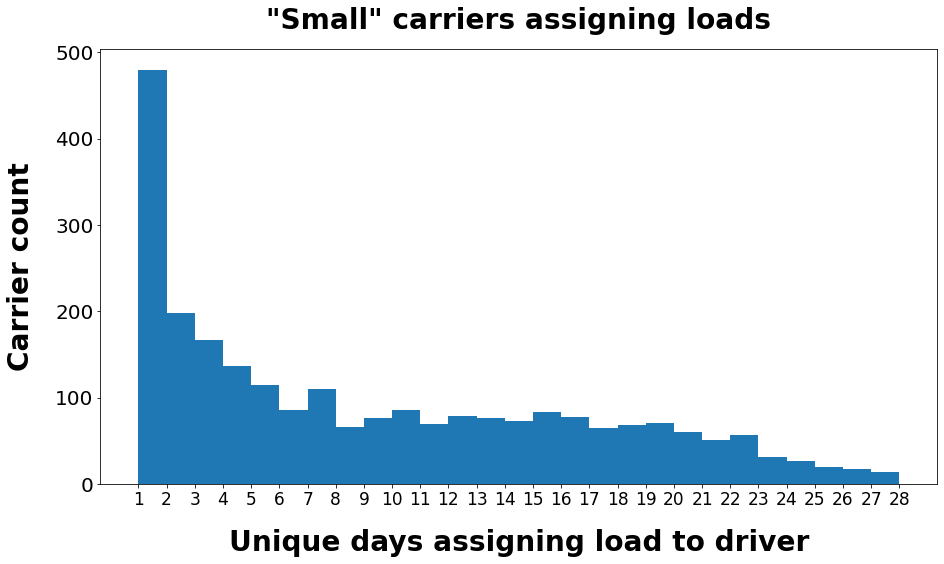

In [12]:
# histogram of unique days of carriers assigning loads to drivers
plt.figure(figsize=(15,8))
plt.hist(result['unique_days_assigning_load'], bins=np.arange(1, 29))
plt.xticks(np.arange(1, 29), fontsize=17)
plt.yticks(fontsize=20)
plt.xlabel('Unique days assigning load to driver', fontsize=28, fontweight='bold', labelpad=20)
plt.ylabel('Carrier count', fontsize=28, fontweight='bold', labelpad=20)
plt.title('"Small" carriers assigning loads', fontsize=28, fontweight='bold', pad=20)
plt.show()

# Now let's segment paid and free users

In [13]:
# creating a table for braintree subscriptions
sql = '''
DROP TABLE IF EXISTS #carrier_with_latest_sub_date
;
SELECT 
carrier_id
,max(created_at) AS last_sub
INTO #carrier_with_latest_sub_date
FROM ctms_db_public.billing_braintreesubscription
WHERE braintree_subscription_status IN ('Active', 'Past Due', 'Pending')
GROUP BY carrier_id
;
SELECT 
#carrier_with_latest_sub_date.carrier_id
,last_sub
,braintree_subscription_status
FROM #carrier_with_latest_sub_date
JOIN ctms_db_public.billing_braintreesubscription
ON #carrier_with_latest_sub_date.carrier_id = billing_braintreesubscription.carrier_id
AND #carrier_with_latest_sub_date.last_sub = billing_braintreesubscription.created_at
WHERE billing_braintreesubscription.braintree_subscription_status IN ('Active', 'Past Due', 'Pending')
;
'''
braintree_subs = pd.read_sql_query(sql, con=engine)
braintree_subs

,carrier_id,last_sub,braintree_subscription_status
0,5466,2016-11-26 09:21:35.868856,Active
1,3298,2016-11-26 09:21:30.983747,Active
2,4925,2017-01-20 15:19:46.097090,Active
3,1421,2017-05-18 13:42:02.182933,Active
4,433,2017-06-19 19:32:44.584252,Active
...,...,...,...
2866,4116,2021-01-18 20:57:54.743970,Active
2867,41286,2020-11-05 22:06:52.942985,Active
2868,36837,2021-01-18 20:43:32.137428,Active
2869,5659,2021-01-18 21:08:43.603265,Active


In [14]:
# joining carriers with braintree table
braintree_with_carriers = braintree_subs.merge(carriers, left_on='carrier_id', right_on='carrier_id')
braintree_with_carriers

,carrier_id,last_sub,braintree_subscription_status,carrier_name,carrier_guid
0,5466,2016-11-26 09:21:35.868856,Active,Rob's Auto Transport LLC,101ce8ba-b529-43c1-80bf-c0f6939ba2a3
1,3298,2016-11-26 09:21:30.983747,Active,Rhoades Logistics LLC,7196d66a-cd25-4ae4-bcdb-15f01b895c2e
2,4925,2017-01-20 15:19:46.097090,Active,Double Time Transport,533c4db9-1f0e-4da2-83e1-ed1385508496
3,1421,2017-05-18 13:42:02.182933,Active,"L&N Transport, LLC",4ba23995-f6ad-4efa-86f8-e3d14d4d9e32
4,433,2017-06-19 19:32:44.584252,Active,FRANK MESSINA,525f3fe2-61bf-452b-b5dd-2ff269a05231
...,...,...,...,...,...
2866,4116,2021-01-18 20:57:54.743970,Active,Vyrado Logistics LLC,ac64fd07-9018-4be7-9c81-fef79f47fbb6
2867,41286,2020-11-05 22:06:52.942985,Active,JVM AUTO TRANSPORT LLC,449569cb-5171-4351-8e9c-25ad36f196e6
2868,36837,2021-01-18 20:43:32.137428,Active,YR AUTO SALES LLC,ef227962-d8f0-4a6f-a60f-b9d97c58ceec
2869,5659,2021-01-18 21:08:43.603265,Active,G'S Auto Hauling Inc,a1ef241d-81d3-47c0-91ec-2ce30e79642a


# Paid users

In [15]:
result_paid_users = (result.merge(braintree_with_carriers, left_on=['carrier_guid', 'carrier_id'],
                                           right_on=['carrier_guid', 'carrier_id']))

result_paid_users = result_paid_users[['carrier_id', 'carrier_guid', 'unique_days_assigning_load']]
result_paid_users['paid_user'] = True
result_paid_users

,carrier_id,carrier_guid,unique_days_assigning_load,paid_user
0,1811,612c0387-b235-40a6-9bbd-8e2a8ec9a09a,12,True
1,42879,944c1ddc-1d89-47b2-86e5-78afa2072646,6,True
2,43172,f085e1dd-ba41-42dc-876b-48d605b1af0e,6,True
3,24813,ac581221-6149-445f-82f7-99f70213a684,21,True
4,16869,b758d49d-64bb-47a1-b3c0-00325c62912a,8,True
...,...,...,...,...
1008,6733,a67fb6cc-db42-4409-aeec-1c05b491527a,22,True
1009,1682,67e2cef2-bd46-476e-b96a-42190b835dd0,22,True
1010,16848,0c81ae62-d93f-4206-b714-081be659bb5c,3,True
1011,6390,c2150c5b-97bf-4c29-beb9-752d935cfad2,6,True


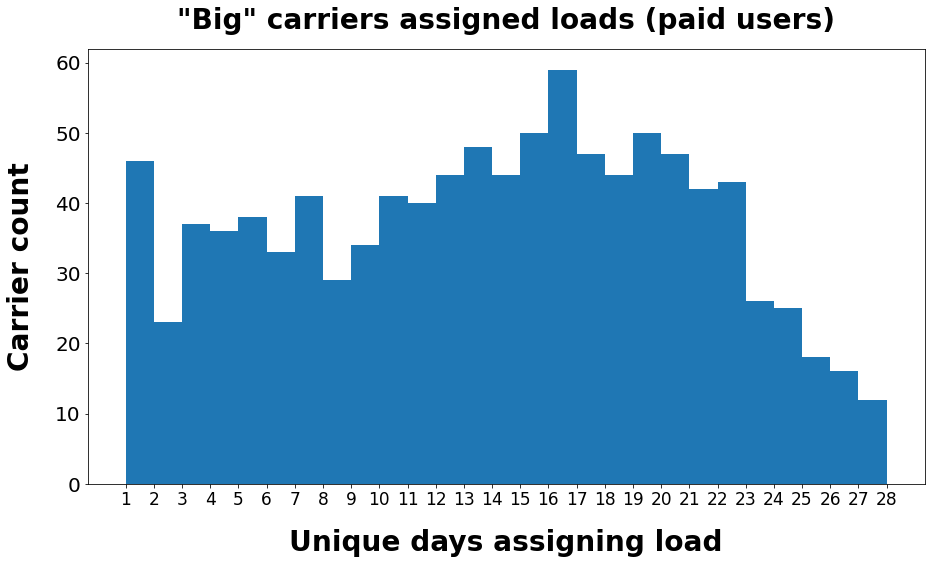

In [16]:
# histogram of unique accepted offers in last 28 days (paid users)
plt.figure(figsize=(15,8))
plt.hist(result_paid_users['unique_days_assigning_load'], bins=np.arange(1, 29))
plt.xticks(np.arange(1, 29), fontsize=17)
plt.yticks(fontsize=20)
plt.xlabel('Unique days assigning load', fontsize=28, fontweight='bold', labelpad=20)
plt.ylabel('Carrier count', fontsize=28, fontweight='bold', labelpad=20)
plt.title('"Big" carriers assigned loads (paid users)', fontsize=28, fontweight='bold', pad=20)
plt.show()

# Free users

In [17]:
result_free_users = (result.merge(braintree_with_carriers, how='left', left_on=['carrier_guid', 'carrier_id'],
                                           right_on=['carrier_guid', 'carrier_id']))

# Free users will have a missing value under braintree_subscription_status
non_payers = result_free_users['braintree_subscription_status'].isna() == True
# dropping all paid user rows
result_free_users = result_free_users[non_payers]
result_free_users = result_free_users[['carrier_id', 'carrier_guid', 'unique_days_assigning_load']]
result_free_users['paid_user'] = False
result_free_users

,carrier_id,carrier_guid,unique_days_assigning_load,paid_user
0,7516,d8eeb04e-1f61-4855-9d8c-9fe364dc8044,15,False
2,16531,4f2b9daa-444a-4c67-8ab3-907976350383,2,False
5,25023,fe1298ef-eb41-4557-a1ef-b266e557ac84,3,False
6,33642,321d9b2c-0b00-41de-9236-e294034610db,1,False
7,18231,c31cccdd-a8db-4f56-9ad5-02e15b677caa,3,False
...,...,...,...,...
2448,18090,1c49e097-dff4-4a80-95f5-7d2268921a45,10,False
2449,18271,17e62317-e67d-4394-97cb-fcb319d471c3,1,False
2453,4529,b120b802-7fbe-4f86-9919-93076bcf6d22,4,False
2454,7611,97d50e10-9bca-43a3-9211-6ba0c48d8d36,6,False


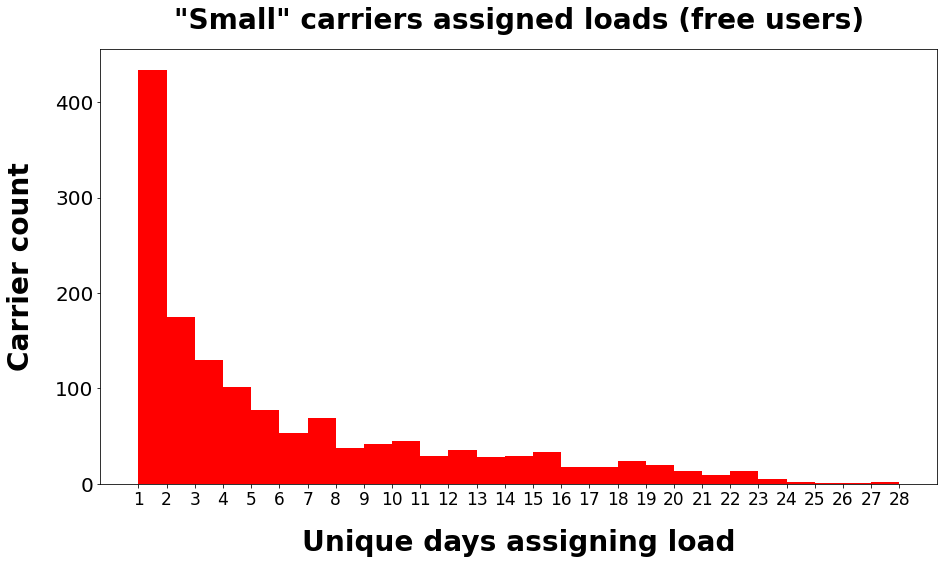

In [18]:
# histogram of unique accepted offers in last 28 days (paid users)
plt.figure(figsize=(15,8))
plt.hist(result_free_users['unique_days_assigning_load'], bins=np.arange(1, 29), color='red')
plt.xticks(np.arange(1, 29), fontsize=17)
plt.yticks(fontsize=20)
plt.xlabel('Unique days assigning load', fontsize=28, fontweight='bold', labelpad=20)
plt.ylabel('Carrier count', fontsize=28, fontweight='bold', labelpad=20)
plt.title('"Small" carriers assigned loads (free users)', fontsize=28, fontweight='bold', pad=20)
plt.show()

In [19]:
total_paid_carriers_for_days_active = []

for i in range(1,29):
    paid_active_carrier_count = (result_paid_users[result_paid_users['unique_days_assigning_load'] >= i]
                           .groupby('unique_days_assigning_load').count()['carrier_guid'].sum())
    
    total_paid_carriers_for_days_active.append(paid_active_carrier_count)
    


total_free_carriers_for_days_active = []

for i in range(1,29):
    free_active_carrier_count = (result_free_users[result_free_users['unique_days_assigning_load'] >= i]
                           .groupby('unique_days_assigning_load').count()['carrier_guid'].sum())
    
    total_free_carriers_for_days_active.append(free_active_carrier_count)

In [20]:
paid_active_carriers = pd.DataFrame()
paid_active_carriers['definition_is_this_many_days_active'] = np.arange(1,29)
paid_active_carriers.set_index('definition_is_this_many_days_active', inplace=True)
paid_active_carriers['total_carriers_at_least_this_active'] = total_paid_carriers_for_days_active
paid_active_carriers['total_percentage_active'] = round(100*paid_active_carriers['total_carriers_at_least_this_active']
                                                       /len(result_paid_users))
paid_active_carriers['total_percentage_dormant'] = 100 - paid_active_carriers['total_percentage_active']


free_active_carriers = pd.DataFrame()
free_active_carriers['definition_is_this_many_days_active'] = np.arange(1,29)
free_active_carriers.set_index('definition_is_this_many_days_active', inplace=True)
free_active_carriers['total_carriers_at_least_this_active'] = total_free_carriers_for_days_active
free_active_carriers['total_percentage_active'] = round(100*free_active_carriers['total_carriers_at_least_this_active']
                                                       /len(result_free_users))
free_active_carriers['total_percentage_dormant'] = 100 - free_active_carriers['total_percentage_active']

In [21]:
def paid_vs_non_paid(paid_metric_definition, non_paid_metric_definition):
    plt.figure(figsize=(13,11))
    plt.subplots_adjust(wspace=.9)
    
    plt.subplot(1,2,1)
    paid_graph = sns.barplot(x=['active', 'dormant'],
                        y=[paid_active_carriers.loc[paid_metric_definition, 'total_carriers_at_least_this_active'],
                           (paid_active_carriers.loc[1, 'total_carriers_at_least_this_active'] - 
                            paid_active_carriers.loc[paid_metric_definition, 'total_carriers_at_least_this_active'])],
                        palette='muted')
    for p in paid_graph.patches:
        paid_graph.annotate(p.get_height(), 
                       (p.get_x() + p.get_width() / 2., p.get_height()), 
                       ha = 'center', va = 'center', 
                       xytext = (0, -20), 
                       textcoords = 'offset points',
                       fontsize=20)
        paid_graph.annotate('{}%'.format(round(100*p.get_height()/paid_active_carriers.loc[1, 'total_carriers_at_least_this_active'])), 
                       (p.get_x() + p.get_width() / 2., p.get_height()), 
                       ha = 'center', va = 'center', 
                       xytext = (0, 15), 
                       textcoords = 'offset points',
                       fontsize=20)
    plt.xticks(fontsize=18, fontweight='bold')
    plt.yticks(fontsize=18)
    plt.ylabel('carrier Count', fontsize=28, fontweight='bold', labelpad=20)
    title = '''If {} out of 28 days
assigned load
(paid users)'''.format(paid_metric_definition)
    plt.title(title, fontsize=28, fontweight='bold', pad=20)

        
    
    plt.subplot(1,2,2)
    non_paid_graph = sns.barplot(x=['active', 'dormant'],
                        y=[free_active_carriers.loc[non_paid_metric_definition, 'total_carriers_at_least_this_active'],
                           (free_active_carriers.loc[1, 'total_carriers_at_least_this_active'] - 
                            free_active_carriers.loc[non_paid_metric_definition, 'total_carriers_at_least_this_active'])],
                        palette='muted')
    for p in non_paid_graph.patches:
        non_paid_graph.annotate(p.get_height(), 
                       (p.get_x() + p.get_width() / 2., p.get_height()), 
                       ha = 'center', va = 'center', 
                       xytext = (0, -20), 
                       textcoords = 'offset points',
                       fontsize=20)
        non_paid_graph.annotate('{}%'.format(round(100*p.get_height()/free_active_carriers.loc[1, 'total_carriers_at_least_this_active'])), 
                       (p.get_x() + p.get_width() / 2., p.get_height()), 
                       ha = 'center', va = 'center', 
                       xytext = (0, 15), 
                       textcoords = 'offset points',
                       fontsize=20)
    plt.xticks(fontsize=18, fontweight='bold')
    plt.yticks(fontsize=18)
    title = '''If {} out of 28 days
assigned load
(free users)'''.format(non_paid_metric_definition)
    plt.title(title, fontsize=28, fontweight='bold', pad=20)
    plt.show()

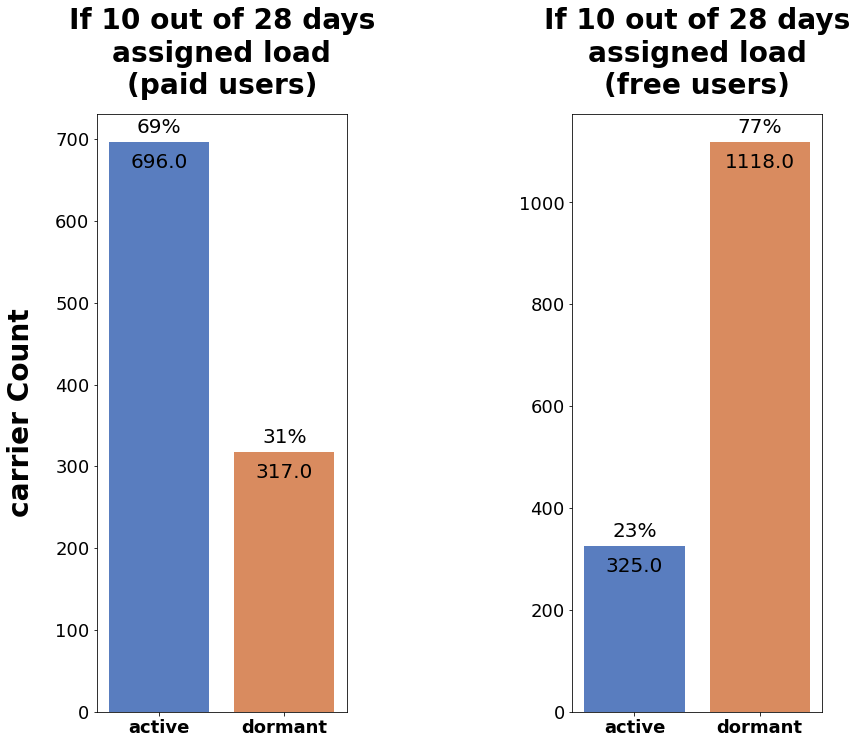

In [22]:
paid_vs_non_paid(10, 10)

In [23]:
all_paid_big_carriers = braintree_with_carriers
all_paid_big_carriers = all_paid_big_carriers.merge(active_driver_count,
                                                    left_on=['carrier_guid', 'carrier_id'],
                                                    right_on=['carrier_guid', 'carrier_id'])
# getting only big carriers
all_paid_big_carriers = all_paid_big_carriers[all_paid_big_carriers['activated_drivers'] > 1]
all_paid_big_carriers

,carrier_id,last_sub,braintree_subscription_status,carrier_name_x,carrier_guid,carrier_name_y,activated_drivers
0,5466,2016-11-26 09:21:35.868856,Active,Rob's Auto Transport LLC,101ce8ba-b529-43c1-80bf-c0f6939ba2a3,Rob's Auto Transport LLC,2
2,4925,2017-01-20 15:19:46.097090,Active,Double Time Transport,533c4db9-1f0e-4da2-83e1-ed1385508496,Double Time Transport,11
4,433,2017-06-19 19:32:44.584252,Active,FRANK MESSINA,525f3fe2-61bf-452b-b5dd-2ff269a05231,FRANK MESSINA,18
5,2634,2016-11-26 09:21:30.293925,Active,Fast Lane Transportation LLC.,61d977bd-62cb-4be7-82b6-54f8a71b4016,Fast Lane Transportation LLC.,2
7,5346,2016-11-26 09:21:35.262542,Active,Roadstar Transportation Services,ace8d77c-fa9a-4cb6-bcb5-569ae3513661,Roadstar Transportation Services,4
...,...,...,...,...,...,...,...
2803,25155,2021-01-18 18:54:07.033626,Active,OV INC,33161d8b-200d-484f-a649-30d32de1638a,OV INC,43
2804,4116,2021-01-18 20:57:54.743970,Active,Vyrado Logistics LLC,ac64fd07-9018-4be7-9c81-fef79f47fbb6,Vyrado Logistics LLC,12
2806,36837,2021-01-18 20:43:32.137428,Active,YR AUTO SALES LLC,ef227962-d8f0-4a6f-a60f-b9d97c58ceec,YR AUTO SALES LLC,21
2807,5659,2021-01-18 21:08:43.603265,Active,G'S Auto Hauling Inc,a1ef241d-81d3-47c0-91ec-2ce30e79642a,G'S Auto Hauling Inc,9


In [24]:
all_free_big_carriers =  carriers.merge(braintree_with_carriers, how='left',
                                        left_on='carrier_guid', right_on='carrier_guid')

# getting all free users
non_payers = all_free_big_carriers['braintree_subscription_status'].isna() == True
# #dropping all rows with paid users
all_free_big_carriers = all_free_big_carriers[non_payers]
# getting only big carriers 
all_free_big_carriers = all_free_big_carriers.merge(active_driver_count,
                                                    left_on='carrier_guid',
                                                    right_on='carrier_guid')
all_free_big_carriers = all_free_big_carriers[all_free_big_carriers['activated_drivers'] > 1]
all_free_big_carriers

,carrier_name_x,carrier_guid,carrier_id_x,carrier_id_y,last_sub,braintree_subscription_status,carrier_name_y,carrier_id,carrier_name,activated_drivers
17,EZ AUTO TRANSPORT LLC,a2740fd1-e415-42b0-8bf8-a38ca3b12896,331,NaN,NaT,NaN,NaN,331,EZ AUTO TRANSPORT LLC,2
21,Cincy Auto Transport,211ba3bc-c5b6-4c4c-88f7-9b391960cf39,390,NaN,NaT,NaN,NaN,390,Cincy Auto Transport,2
22,TransportMYcarz Logistics,8cc23bd1-ce03-40a6-a81e-12764826adc2,419,NaN,NaT,NaN,NaN,419,TransportMYcarz Logistics,2
26,Lenz Auto,c71306a3-5fee-4aaf-a484-a62c65ab5087,537,NaN,NaT,NaN,NaN,537,Lenz Auto,2
40,LionBear Logistics LLC,f199f6f6-ca00-4b3d-8e1d-dc1f5759d572,706,NaN,NaT,NaN,NaN,706,LionBear Logistics LLC,3
...,...,...,...,...,...,...,...,...,...,...
35669,STAR FLEET TRUCKING INC,e4e1df57-3b56-48e4-8610-11125e4efc11,21858,NaN,NaT,NaN,NaN,21858,STAR FLEET TRUCKING INC,4
35670,BSL TRANSPORT LLC,4eeca8bd-fde2-485d-b967-65e1a8b77b06,37443,NaN,NaT,NaN,NaN,37443,BSL TRANSPORT LLC,2
35672,WILL TRANSPORT LLC,3df83796-57fb-4fbf-8a57-954423cf98d8,33856,NaN,NaT,NaN,NaN,33856,WILL TRANSPORT LLC,2
35674,SMITH AUTO TRANSPORT,e2ddafd8-c53b-463e-ba0c-106056aa9eaa,32770,NaN,NaT,NaN,NaN,32770,SMITH AUTO TRANSPORT,10


In [25]:
paid_active_carriers = pd.DataFrame()
paid_active_carriers['definition_is_this_many_days_active'] = np.arange(1,29)
paid_active_carriers.set_index('definition_is_this_many_days_active', inplace=True)
paid_active_carriers['total_carriers_at_least_this_active'] = total_paid_carriers_for_days_active
paid_active_carriers['total_dormant_carriers'] = ([len(all_paid_big_carriers) - total_paid_carriers_for_days_active[x]
                                                 for x in range(len(total_paid_carriers_for_days_active))]) 
paid_active_carriers['total_percentage_active'] = round(100*paid_active_carriers['total_carriers_at_least_this_active']
                                                      /len(all_paid_big_carriers))
paid_active_carriers['total_percentage_dormant'] = 100 - paid_active_carriers['total_percentage_active']


free_active_carriers = pd.DataFrame()
free_active_carriers['definition_is_this_many_days_active'] = np.arange(1,29)
free_active_carriers.set_index('definition_is_this_many_days_active', inplace=True)
free_active_carriers['total_carriers_at_least_this_active'] = total_free_carriers_for_days_active
free_active_carriers['total_dormant_carriers'] = ([len(all_free_big_carriers) - total_free_carriers_for_days_active[x]
                                                 for x in range(len(total_free_carriers_for_days_active))])
free_active_carriers['total_percentage_active'] = round(100*free_active_carriers['total_carriers_at_least_this_active']
                                                      /len(all_free_big_carriers))
free_active_carriers['total_percentage_dormant'] = 100 - free_active_carriers['total_percentage_active']

In [26]:
def all_users(paid_metric_definition, free_metric_definition):
    plt.figure(figsize=(13,11))
    plt.subplots_adjust(wspace=.9)
    
    plt.subplot(1,2,1)
    paid_graph = sns.barplot(x=['active', 'dormant'],
                        y=[paid_active_carriers.loc[paid_metric_definition, 'total_carriers_at_least_this_active'],
                           paid_active_carriers.loc[paid_metric_definition, 'total_dormant_carriers']],
                        palette='muted')
    for p in paid_graph.patches:
        paid_graph.annotate(p.get_height(), 
                       (p.get_x() + p.get_width() / 2., p.get_height()), 
                       ha = 'center', va = 'center', 
                       xytext = (0, -20), 
                       textcoords = 'offset points',
                       fontsize=20)
        paid_graph.annotate('{}%'.format(round(100*p.get_height()/len(all_paid_big_carriers))), 
                       (p.get_x() + p.get_width() / 2., p.get_height()), 
                       ha = 'center', va = 'center', 
                       xytext = (0, 15), 
                       textcoords = 'offset points',
                       fontsize=20)
    plt.xticks(fontsize=18, fontweight='bold')
    plt.yticks(fontsize=18)
    plt.ylabel('Carrier Count', fontsize=28, fontweight='bold', labelpad=20)
    title = '''If {} out of 28 days
assigning load
(paid users)'''.format(paid_metric_definition)
    plt.title(title, fontsize=28, fontweight='bold', pad=20)

        
    
    plt.subplot(1,2,2)
    non_paid_graph = sns.barplot(x=['active', 'dormant'],
                        y=[free_active_carriers.loc[free_metric_definition, 'total_carriers_at_least_this_active'], 
                           free_active_carriers.loc[free_metric_definition, 'total_dormant_carriers']],
                        palette='muted')
    for p in non_paid_graph.patches:
        non_paid_graph.annotate(p.get_height(), 
                       (p.get_x() + p.get_width() / 2., p.get_height()), 
                       ha = 'center', va = 'center', 
                       xytext = (0, -20), 
                       textcoords = 'offset points',
                       fontsize=20)
        non_paid_graph.annotate('{}%'.format(round(100*p.get_height()/len(all_free_big_carriers))), 
                       (p.get_x() + p.get_width() / 2., p.get_height()), 
                       ha = 'center', va = 'center', 
                       xytext = (0, 15), 
                       textcoords = 'offset points',
                       fontsize=20)
    plt.xticks(fontsize=18, fontweight='bold')
    plt.yticks(fontsize=18)
    title = '''If {} out of 28 days
assigning load
(free users)'''.format(free_metric_definition)
    plt.title(title, fontsize=28, fontweight='bold', pad=20)
    plt.show()

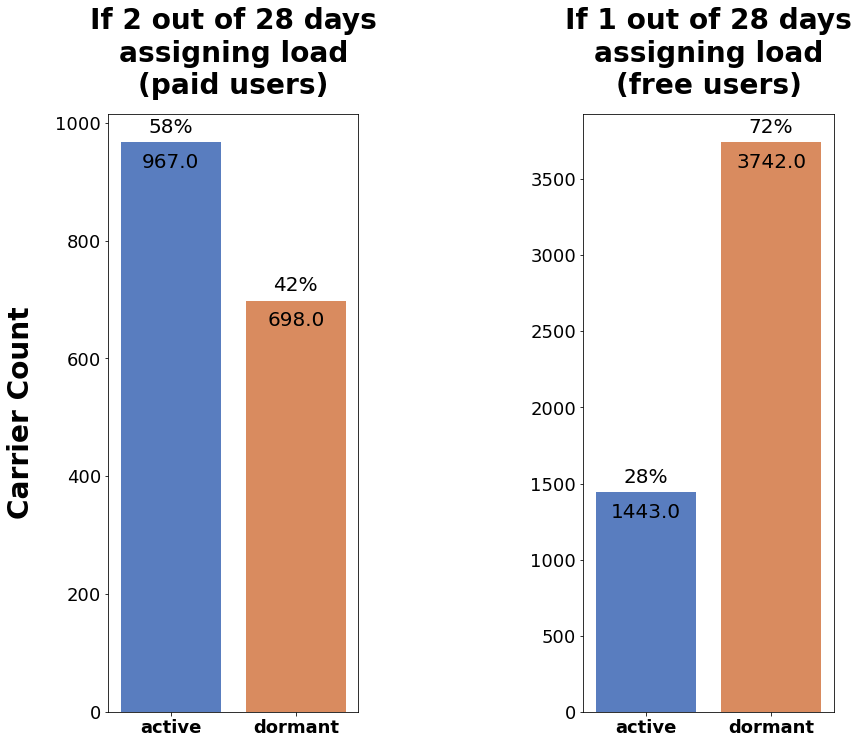

In [27]:
all_users(2,1)